# Report - Challenge 2: Binary classification
## TDT05 Modern Machine Learning in Practice
### By Group 2-AM (Adrian Langseth & Magnus Reier Rushfeldt)

# Introduction

In this report, the process and result of creating a machine learning model to perform binary classification on a 100K x 29 size dataset (100K rows with 29 features each) will be presented. Each instance belongs to one of two classes, and the goal was to create a model that could predict the classes of unseen instances as accurate as possible (evaluated by the ROC-AUC metric).

# Content
1. [Exploratory Data Analysis](#exploratory-data-analysis)
1. [Data Preprocessing](#data-preprocessing)
1. [Model Choice and Training](#model-choice-and-training)
1. [Prediction Results](#prediction-results)
1. [Interpretation](#interpretation)

## Imports

In [1]:
import os
import pandas as pd
import numpy as np
import lime
import pandas_profiling as pp

from collections import Counter, Iterable
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import xgboost as xgb
from catboost import CatBoostClassifier, Pool
from preproc_featenigneering import clean_feature_engineer

from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, auc, roc_curve, roc_auc_score, recall_score, accuracy_score, \
    precision_recall_curve
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.inspection import PartialDependenceDisplay
from sklearn.tree import DecisionTreeClassifier, plot_tree
from tqdm import tqdm

from catboost import CatBoostClassifier
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier

C:\Users\n647770\AppData\Local\Temp/ipykernel_1088/3729916665.py:7: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Counter, Iterable
C:\Users\n647770\Anaconda3\envs\TDT05\lib\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


# Exploratory Data Analysis

## Initial Exploration

Before we perform any feature engineering and start training models, we need to explore properties of the data. We first open the training dataset and load it into a dataframe:

In [2]:
data_file = '../tdt05-2021-challenge-2/challenge2_train.csv'
df = pd.read_csv(data_file)
df

id  target   f0  f1 f2   f3   f4    f5   f6   f7  ...  f19  f20  \
0          0       0  1.0  gL  e  3.0    A   NaN  0.0  6.0  ...  0.5  0.0   
1          1       0  0.0  Rj  c  1.0    A   7.0  1.0  4.0  ...  0.4  0.0   
2          2       0  NaN  In  a  1.0    A  10.0  1.0  6.0  ...  0.5  1.0   
3          3       1  1.0  rA  c  3.0    A   7.0  1.0  1.0  ...  0.6  1.0   
4          4       0  1.0  pE  c  3.0    A   7.0  0.0  6.0  ...  0.5  0.0   
...      ...     ...  ...  .. ..  ...  ...   ...  ...  ...  ...  ...  ...   
49995  49995       1  0.0  tT  d  3.0  NaN  11.0  0.0  1.0  ...  0.6  1.0   
49996  49996       0  1.0  pB  b  2.0    A   7.0  0.0  6.0  ...  0.1  0.0   
49997  49997       0  0.0  TL  e  1.0    A  11.0  0.0  6.0  ...  NaN  0.0   
49998  49998       0  0.0  Bx  a  1.0    A   7.0  1.0  4.0  ...  0.4  0.0   
49999  49999       0  0.0  Pw  f  1.0    A  10.0  0.0  6.0  ...  NaN  1.0   

       f21  f22        f23       f24 f25 f26  f27      f28  
0      3.0    R  328b0cf4e  0.834041   T   N  1.0  14.2364  
1      1.0  NaN  328b0cf4e  0.686021   T   N  1.0      NaN  
2      3.0    G  0c67fcbbd  1.141271   T   N  3.0      NaN  
3      1.0    G  fee4e3007  0.662382   T   N  3.0      NaN  
4      1.0    B  587e040bd -1.000000   T   N  1.0  13.9537  
...    ...  ...        ...       ...  ..  ..  ...      ...  
49995  1.0    R  72ccba7a4  0.890576   T   N  3.0  14.0466  
49996  7.0    R  250eea49d       NaN   T   N  1.0  14.0157  
49997  7.0    G  110d4786e  1.327592   T   N  1.0  13.9255  
49998  3.0    R  0dcf409af  0.842615   T   S  1.0  14.3062  
49999  5.0    G  098d9fef5  0.996243   F   N  3.0      NaN  

[50000 rows x 31 columns]

We see that the training set has 50000 rows, each with an ID, a target value (the class label to be predicted later), and 29 features. The ID is not necessary for now, as it can be derived implicitly from the row's index. It could also be useful to look at the training set without the target labels:L

In [3]:
# We first remove ID from the original data frame, and create a new one without target
df = df.drop(labels=['id'], axis=1)
df_feat = df.drop(labels=['target'], axis=1)

Let's explore some properties of each feature, and how they relate to each other, by sampling 10% of the dataset and generating some statistics on it:

In [4]:
sample_profile=df.sample(frac=0.1)
pp.ProfileReport(sample_profile)

Render HTML: 100%|██████████| 1/1 [00:03<00:00,  3.54s/it]


From the *Overview* tab we see that, of the 5000 rows that were sampled, 4.5% of the cells are missing, while none of the rows are duplicated. It seems then that there are zero or few duplicate rows in the entire training dataset. To confirm this, we drop them from the training set and check the new size:

In [5]:
df = df.drop_duplicates()
df.shape

(50000, 30)

This is indeed the case. We also see that the profiling report has estimated that 11 of the features are numerical, 20 are categorical, and 1 is boolean. This will be investigated further in the next section.

## Individual features
By looking at the *Variables* tab, we can explore individual feature statistics

### Missing values
We see that there are some missing values for f5, f17 and f28. To confirm how much values are missing, we calculate the percent missing of the full dataset:

In [6]:
def plot_missing(df):
    percent_missing = [df[col].isnull().sum()/len(df) for col in df.columns]
    missing_values = pd.DataFrame({'Proportion_of_total_rows': percent_missing}, index=df.columns)
    missing_values.plot.barh()

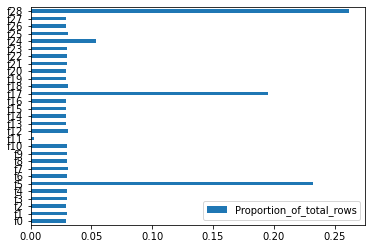

In [7]:
plot_missing(df_feat)

We see that f5, f17 and f28 all have a relatively large percent (17-25%) of missing values. These columns therefore need to have their missing values properly imputed, or the features might have to be removed alltogether.

### Feature statistics

We see that the features f0, f4, f6, f25 and f26, four of which the profiler deemed categorical, each only have 2 possible values. They are then, in fact, also boolean/binary. In any case, these categorical features, along with f2, f3, f9, f18, f20, f22 and f27, have small value ranges that seem to be fully categorical and non-ordinal in nature (no apparent order between the values), so they should be engineered to account for this.

On the other hand, the categorical features f1, f8, f10, f12, f13, f14, f15 and f23 all have high cardinality in their value ranges, some almost on the same order of magnitude as their number of instances. This might either indicate that they are nominal (encoding an almost unique or rare trait, i.e. not useful for finding patterns), or that they are in fact numerical interval/ratio values encoded as alphanumerical and/or hex values. These values should then be engineered differently. They might have to be grouped in ranges and/or converted to numerical interval values and normalized.

Finally, the real number features have varying distributions of their value ranges. Some have only a few distinct values, like f5, f7, f16, f19 and f21, while others are continous and have clear distributions, like f11, f17, f24 and f28. Specifically, f11 and f28 seems to have a somewhat normal/bell curve distribution, while f17 and f24 seem to have exponential/long tail distributions. In addition, f24 seems to have missing/faulty values encoded as '-1', which must also be dealt with.

### Target distribution

We see that the two target labels, '0' and '1', are quite unevenly distributed in the sample. We check if this is also the case in the full dataset:

<AxesSubplot:ylabel='Frequency'>

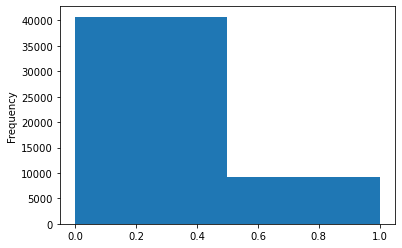

In [8]:
df['target'].plot.hist(bins=2)

In [9]:
df[['target']].value_counts()

target
0         40744
1          9256
dtype: int64

With almost 41K rows labeled '0' and a little over 9K rows labeled '1', the dataset is quite imbalanced (around a 4:1 ratio of rows between the classes). This means that the dataset must either be resampled, or we must account for the imbalance in model selection, training and/or evaluation. The AUC-ROC-metric should take class imbalance into account when evaluating model performance.

## Feature relations
To look at how the features relate to each other, we study the info in the *Correlations* tab

We see that most features are hardly correlating at all with other features, except for some combinations. There is also some slight correlation between the target and the features f3 and f5, which might indicate a useful pattern for prediction. Therefore, the feature pairs f5-f17, f5-f24, f17-f24 and f20-f27, and the target-feature pairs target-f3 and target-f5, will be further examined:

<AxesSubplot:xlabel='f5', ylabel='f17'>

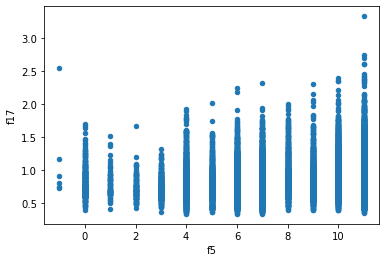

In [10]:
# We use a scatter plot since f17 has a continous interval (floating point) value range
df.plot.scatter('f5', 'f17')

<AxesSubplot:xlabel='f5', ylabel='f24'>

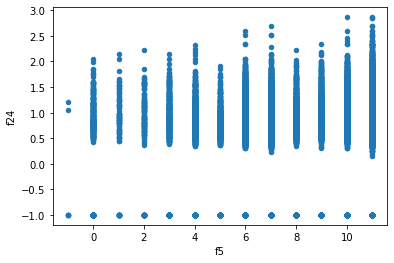

In [11]:
# We use a scatter plot since f24 has a continous interval (floating point) value range
df.plot.scatter('f5', 'f24')

<AxesSubplot:xlabel='f17', ylabel='f24'>

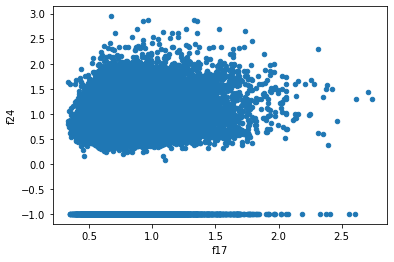

In [12]:
# We use a scatter plot since f17 and f24 both have continous interval (floating point) value ranges
df.plot.scatter('f17', 'f24')

In [13]:
# We use a correlation matrix since f20 and f27 both have ordinal/categorical (integer) value ranges
pd.crosstab(df['f20'], df['f27'], normalize="index", dropna=False)

f27   1.0  2.0  3.0  4.0
f20                     
0.0   1.0  0.0  0.0  0.0
1.0   0.0  0.0  1.0  0.0
10.0  0.0  0.0  0.0  1.0
11.0  0.0  1.0  0.0  0.0

In [14]:
# We use a correlation matrix since both f3 and the target have ordinal/categorical (integer) value ranges
pd.crosstab(df['f3'], df['target'], normalize="index", dropna=False)

target         0         1
f3                        
1.0     0.861460  0.138540
2.0     0.813581  0.186419
3.0     0.761279  0.238721

In [15]:
# We use a correlation matrix since both f16 and the target have ordinal/categorical (integer) value ranges
pd.crosstab(df['f16'], df['target'], normalize="index", dropna=False)

target         0         1
f16                       
1.0     0.881785  0.118215
2.0     0.886866  0.113134
3.0     0.846301  0.153699
4.0     0.849917  0.150083
5.0     0.832337  0.167663
6.0     0.766330  0.233670
7.0     0.799547  0.200453
8.0     0.808697  0.191303
9.0     0.790487  0.209513
10.0    0.800000  0.200000
11.0    0.758613  0.241387
12.0    0.776183  0.223817

There is some slight correlation between the feature pairs of f5-f17, f5-f24, f17-f24, but this should not warrant any change in how these features are engineered. However, we see that the values of feature f20 maps exactly one-to-one to the values of f27, meaning that both features seem to encode exactly the same (or directly related) information. Since including both features will not add any useful information to the learner, one of them can be dropped.

When it comes to correlation between the features f3 and f16 and the target, we see that there certainly is some correlation between them. Both f3 and f16 has an increasing chance of belonging to class '1' with increasing values. This information might help us use these features better to predict the target.

Since f7 and f21 both have 6-7 distinct numerical values between 1 and 6/7, they seem to maybe encode weekdays. Similarly, f5 and f16 seen to have 12-13 distinct values between 0/1 (not counting -1, as it is probably an encoding for an invalid/missing value) and 11/12, which might encode month in a year. In this case, the values are cyclical intervals, and should be encoded properly to account for this. To check that, we study the correlation matrices of target-f5, target-f7, target-f16 (this matrix is already shown above) and target-f21:

In [16]:
pd.crosstab(df['f5'], df['target'], normalize="index", dropna=False)

target         0         1
f5                        
-1.0    0.500000  0.500000
 0.0    0.811321  0.188679
 1.0    0.823529  0.176471
 2.0    0.877698  0.122302
 3.0    0.841346  0.158654
 4.0    0.828041  0.171959
 5.0    0.811400  0.188600
 6.0    0.819516  0.180484
 7.0    0.811861  0.188139
 8.0    0.799386  0.200614
 9.0    0.812918  0.187082
 10.0   0.810377  0.189623
 11.0   0.820182  0.179818

In [17]:
pd.crosstab(df['f7'], df['target'], normalize="index", dropna=False)

target         0         1
f7                        
1.0     0.794047  0.205953
2.0     0.831706  0.168294
3.0     0.856067  0.143933
4.0     0.821836  0.178164
5.0     0.794229  0.205771
6.0     0.839340  0.160660

In [18]:
pd.crosstab(df['f21'], df['target'], normalize="index", dropna=False)

target         0         1
f21                       
1.0     0.786629  0.213371
2.0     0.800690  0.199310
3.0     0.838713  0.161287
4.0     0.861237  0.138763
5.0     0.837612  0.162388
6.0     0.804710  0.195290
7.0     0.788561  0.211439

It seems that f21 is cyclical (thus encoding day of the week), since the correlation to target for instances of both value '1' and '7' are almost identical, and the distance between '1' and '2', and '6' and '7', is also very similar, meaning the correlation between target and day of week follow a sine/periodical distribution.

# Data Preprocessing

Based on what we found during EDA, we perform preprocessing of the dataset.

## Preprocessing function

The function `clean_feature_engineer()` performs cleaning and feature engineering of the datasets that are given as parameters.

In [19]:
def clean_feature_engineer(fp_train:str = "../tdt05-2021-challenge-2/challenge2_train.csv",
                           fp_test:str = "../tdt05-2021-challenge-2/challenge2_test.csv",
                           fillnans:bool = False,
                           indiscriminately_scale:bool = False):
    """
    Does Feature engineering and data cleaning.
    :param fp_train: filepath to train dataset (csv)
    :param fp_test: filepath to train dataset (csv)
    :param fillnans: bool indicating wether to fillnans
    :return: X_train, X_test, y-train
    """
    original_train = pd.read_csv(fp_train)
    original_test = pd.read_csv(fp_test)

    y_tr = original_train['target'].apply(lambda x: int(x) if pd.notnull(x) else x)
    X_tr = original_train.copy(deep=True)
    X_ts = original_test.copy(deep=True)

    X_tr.drop(['id', 'target'], axis=1, inplace=True)
    X_ts.drop(['id'], axis=1, inplace=True)

    ordinal = ['f1', 'f2', 'f3', 'f5', 'f7', 'f10', 'f18', 'f19', 'f27']
    num_ords = ['f3', 'f5', 'f7', 'f19', 'f27']
    alpha_ords = ['f1', 'f2', 'f10', 'f18']

    numeric = ['f11', 'f17', 'f24', 'f28']
    bell_curve = ['f11', 'f28']
    long_tail = ['f17', 'f24']  # F24 has -1 as null values. Remove before scaling

    binary = ['f0', 'f4', 'f6', 'f25', 'f26']
    cyclical = ['f16', 'f21']
    nominal = ['f8', 'f9', 'f12', 'f14', 'f15', 'f22', 'f23']  # hexes
    duplicate = ['f20']

    # BINARY
    bin_encoding = {float(0): 0, 'A': 0, 'F': 0, 'S': 0, float(1): 1, 'B': 1, 'T': 1, 'N': 1}
    for col in binary:
        X_tr[col] = X_tr[col].map(bin_encoding)
        X_ts[col] = X_ts[col].map(bin_encoding)

    # Numericals

    # BELL CURVES

    scl = StandardScaler()
    X_tr[['f11', 'f28']] = scl.fit_transform(X_tr[['f11', 'f28']])
    X_ts[['f11', 'f28']] = scl.transform(X_ts[['f11', 'f28']])

    # since we have normalized the bellcurve around 1, we believe we can impute 0 in Null's
    X_tr[['f11', 'f28']] = X_tr[['f11', 'f28']].fillna(value=0)
    X_ts[['f11', 'f28']] = X_ts[['f11', 'f28']].fillna(value=0)

    # LONG TAILS. Strat: Log the shit out of them to push onto bell curve, then scale them.
    X_tr[['f24']].replace(-1.0, np.nan, inplace=True)
    X_ts[['f24']].replace(-1.0, np.nan, inplace=True)

    X_tr[['f17', 'f24']] = np.log(X_tr[['f17', 'f24']])
    X_ts[['f17', 'f24']] = np.log(X_ts[['f17', 'f24']])

    scl = StandardScaler()
    X_tr[['f17', 'f24']] = scl.fit_transform(X_tr[['f17', 'f24']])
    X_ts[['f17', 'f24']] = scl.transform(X_ts[['f17', 'f24']])

    # since we have normalized the bellcurve around 1, we believe we can impute 0 in Null's.
    # Not really sure about this one though.
    X_tr[['f17', 'f24']] = X_tr[['f17', 'f24']].fillna(value=0)
    X_ts[['f17', 'f24']] = X_ts[['f17', 'f24']].fillna(value=0)

    # ORDINAL (OrdinalEncoder)
    ordinals = ['f1_0', 'f1_1', 'f2', 'f3', 'f5', 'f7', 'f10', 'f13', 'f18', 'f19', 'f27']
    numerical_ordinals = ['f3', 'f5', 'f7', 'f19', 'f27']
    usable_ordinals = ['f3', 'f5', 'f7', 'f27']
    alphabetical_ordinals = ['f1_0', 'f1_1', 'f2', 'f10', 'f13', 'f18']
    CAPS_ONLY = ['f10', 'f18']
    lower_only = ['f2', 'f13']
    MiX = ['f1_0', 'f1_1']

    assert set(alphabetical_ordinals).isdisjoint(numerical_ordinals)
    assert set(CAPS_ONLY).isdisjoint(lower_only)
    assert set(CAPS_ONLY).isdisjoint(MiX)
    assert set(MiX).isdisjoint(lower_only)

    # split f1 on letter
    X_tr['f1_0'] = X_tr['f1'].apply(lambda x: x[0] if type(x) is str else x)
    X_tr['f1_1'] = X_tr['f1'].apply(lambda x: x[0] if type(x) is str else x)
    X_ts['f1_0'] = X_ts['f1'].apply(lambda x: x[0] if type(x) is str else x)
    X_ts['f1_1'] = X_ts['f1'].apply(lambda x: x[0] if type(x) is str else x)

    X_tr.drop(['f1'], axis=1, inplace=True)
    X_ts.drop(['f1'], axis=1, inplace=True)

    for col_name in ordinals:
        if col_name in numerical_ordinals and col_name not in usable_ordinals:
            X_tr[col_name] = X_tr[col_name].apply(lambda x: x * 10 if not pd.notnull(x) else x)
            X_ts[col_name] = X_ts[col_name].apply(lambda x: x * 10 if not pd.notnull(x) else x)
        elif col_name in alphabetical_ordinals:
            if col_name in CAPS_ONLY:
                X_tr[col_name] = X_tr[col_name].apply(lambda x: ord(x) - ord('A') if pd.notnull(x) else x)
                X_ts[col_name] = X_ts[col_name].apply(lambda x: ord(x) - ord('A') if pd.notnull(x) else x)
            elif col_name in lower_only:
                X_tr[col_name] = X_tr[col_name].apply(lambda x: ord(x) - ord('a') if pd.notnull(x) else x)
                X_ts[col_name] = X_ts[col_name].apply(lambda x: ord(x) - ord('a') if pd.notnull(x) else x)
            elif col_name in MiX:
                X_tr[col_name] = X_tr[col_name].apply(lambda x: (
                    ord(x) - ord('a') + (ord('Z') - ord('A') + 1) if x.islower() else ord(x) - ord('A')) if pd.notnull(
                    x) else x)
                X_ts[col_name] = X_ts[col_name].apply(lambda x: (
                    ord(x) - ord('a') + (ord('Z') - ord('A') + 1) if x.islower() else ord(x) - ord('A')) if pd.notnull(
                    x) else x)
            else:
                raise ValueError("Something wrong with the sets...")

    # NOMINAL (OneHotEncoder)

    high_cardinality_noms = [i for i in nominal if X_tr[i].nunique() > 10]  # Hexes
    low_cardinality_noms = [i for i in nominal if i not in high_cardinality_noms]

    # Onehot for low cardinality Noms

    X_tr = X_tr.join(pd.get_dummies(X_tr[low_cardinality_noms], dummy_na=False, drop_first=False))
    X_tr.drop(low_cardinality_noms, axis=1, inplace=True)

    X_ts = X_ts.join(pd.get_dummies(X_ts[low_cardinality_noms], dummy_na=False, drop_first=False))
    X_ts.drop(low_cardinality_noms, axis=1, inplace=True)

    # ToDo: need to do ordinal on this
    for nom in high_cardinality_noms:
        X_tr[nom] = X_tr[nom].apply(lambda x: int(x[0], 16) if pd.notnull(x) else x)
        X_ts[nom] = X_ts[nom].apply(lambda x: int(x[0], 16) if pd.notnull(x) else x)

    # CYCLICAL

    ## We believe f16 is month
    X_tr['f16_sin'] = np.sin((X_tr['f16'] - 1) * (2. * np.pi / 12))
    X_tr['f16_cos'] = np.cos((X_tr['f16'] - 1) * (2. * np.pi / 12))

    X_ts['f16_sin'] = np.sin((X_ts['f16'] - 1) * (2. * np.pi / 12))
    X_ts['f16_cos'] = np.cos((X_ts['f16'] - 1) * (2. * np.pi / 12))

    X_tr['f16_sin'].fillna(0, inplace=True)
    X_tr['f16_cos'].fillna(0, inplace=True)
    X_ts['f16_sin'].fillna(0, inplace=True)
    X_ts['f16_cos'].fillna(0, inplace=True)

    X_tr.drop(['f16'], axis=1, inplace=True)
    X_ts.drop(['f16'], axis=1, inplace=True)

    ## We believe f21 is dayOfWeek
    X_tr['f21_sin'] = np.sin((X_tr['f21'] - 1) * (2. * np.pi / 7))
    X_tr['f21_cos'] = np.cos((X_tr['f21'] - 1) * (2. * np.pi / 7))

    X_ts['f21_sin'] = np.sin((X_ts['f21'] - 1) * (2. * np.pi / 7))
    X_ts['f21_cos'] = np.cos((X_ts['f21'] - 1) * (2. * np.pi / 7))

    X_tr['f21_sin'].fillna(0, inplace=True)
    X_tr['f21_cos'].fillna(0, inplace=True)
    X_ts['f21_sin'].fillna(0, inplace=True)
    X_ts['f21_cos'].fillna(0, inplace=True)

    X_tr.drop(['f21'], axis=1, inplace=True)
    X_ts.drop(['f21'], axis=1, inplace=True)

    # DUPLICATES
    X_tr.drop(['f27'], axis=1, inplace=True)
    X_ts.drop(['f27'], axis=1, inplace=True)

    if fillnans:
        X_tr.fillna(X_tr.mean(), inplace=True)
        X_ts.fillna(X_ts.mean(), inplace=True)

    if indiscriminately_scale:
        scl = StandardScaler()
        X_tr = scl.fit_transform(X_tr)
        X_ts = scl.transform(X_ts)

    return X_tr, X_ts, y_tr

## Preprocessing

Using the preprocessing function `clean_feature_engineer()`, both the training data, training labels, and test data are preprocessed and extracted:

In [20]:
fp_train = "../tdt05-2021-challenge-2/challenge2_train.csv"
fp_test = "../tdt05-2021-challenge-2/challenge2_test.csv"
X_tr, X_ts, y_tr = clean_feature_engineer()
print(X_tr.dtypes)
print(X_ts.dtypes)
print(y_tr.dtypes)

C:\Users\n647770\Anaconda3\envs\TDT05\lib\site-packages\pandas\core\frame.py:5238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


f0           float64
f2           float64
f3           float64
f4           float64
f5           float64
f6           float64
f7           float64
f8           float64
f10          float64
f11          float64
f12          float64
f13          float64
f14          float64
f15          float64
f17          float64
f18          float64
f19          float64
f20          float64
f23          float64
f24          float64
f25          float64
f26          float64
f28          float64
f1_0         float64
f1_1         float64
f9_black       uint8
f9_green       uint8
f9_red         uint8
f9_white       uint8
f9_yellow      uint8
f22_B          uint8
f22_G          uint8
f22_R          uint8
f16_sin      float64
f16_cos      float64
f21_sin      float64
f21_cos      float64
dtype: object
f0           float64
f2           float64
f3           float64
f4           float64
f5           float64
f6           float64
f7           float64
f8           float64
f10          float64
f11          float64

## Reroute

After a reroute in choice of model as described in [Model Choice and Training](#model-choice-and-training), we took a more category-centric approach. This meant focusing more on converting those categories which had a clear and meaningful numeric distribution, which was reflected in the coocurrance matrices, and leaving the other categories as be and letting the models handle the categories. This led to the preprocessing shown in the short report. Please see the short report for code on this.

In the stacking model we used a target encoder for the categorical values. This was tested against the regular encoding and performed better. Therefore this was used. Please see the short report for code on this. 

# Model Choice and Training

## Model Choice

Several models were chosen and tried out. There are different reasons for each, where xgBoost is a good handler of the many Null values in the dataset and decisionTree was selected for simplicity. Catboost was a popular choice in the class and was tried for this reason. Many were tried and several blends were attempted.

## Predictor classes

The classes below are wrapper classes for getting data for, training, storing and predicting using the given classifier model. The superclass `Predictor` defines this interface. Meanwhile, the `Predictor` subclasses `xgBoostPredictor`, `LogisticRegressionPredictor`, `DecisionTreePredictor` and `CatBoostPredictor` all implement the interfaces for the corresponding classifier models. There's also a function `blend()` for blending/stacking the results of several predictors into one final prediction.

In [21]:
class Predictor:
    def _get_data(self):
        """
        Gets required data from preproc_featengineering.
        :return: Returns Data on form (x_train, x_test, y_train).
        """
        raise NotImplementedError("Must implement in subclass")

    def fit(self):
        """
        Fits model on data with conventional method.
        :return: None
        """
        raise NotImplementedError("Must implement in subclass")

    def fit_cv(self):
        """
        Fits model on data with cross validation.
        :return: (list of roc_auc scores of train, list of roc_auc scores of validation)
        """
        raise NotImplementedError("Must implement in subclass")

    def predict(self):
        """
        Predicts on the test data.
        :return: A 1D array of floats representing confidence of true value.
        """
        raise NotImplementedError("Must implement in subclass")

    def save_model(self, model_fp):
        """
        Saves fitted model to file.
        :return: None.
        """
        raise NotImplementedError("Must implement in subclass")

    def load_model(self, model_fp):
        """
        Loads fitted model from file.
        :return: None.
        """
        raise NotImplementedError("Must implement in subclass")


class xgBoostPredictor(Predictor):
    """
    xgboost predictor class
    todo:
    - Implement stratified KFold such as in Logreg
    """

    def __init__(self):
        self.x_tr, self.x_ts, self.y_tr = self._get_data()

        counter = Counter(self.y_tr)
        imbalancedness = counter[0] / counter[1]
        self.clf = xgb.XGBRegressor(n_estimators=800, objective="binary:logistic", scale_pos_weight=imbalancedness,
                                    eval_metric='auc',
                                    random_state=42)

    def _get_data(self):
        return clean_feature_engineer()

    def fit(self):
        x_train, x_val, y_train, y_val = train_test_split(self.x_tr, self.y_tr, test_size=0.2, random_state=42)
        self.clf.fit(x_train, y_train, eval_set=[(x_val, y_val)], eval_metric=['auc'], early_stopping_rounds=20,
                     verbose=False)

    def fit_cv(self, plot=False):
        train_scores = []
        val_scores = []
        y_validations = []
        y_predictions = []
        best_iterations = []
        cv_test_preds = np.zeros(len(self.x_ts))
        FOLDS=5

        for index_train, index_val in tqdm(StratifiedKFold(n_splits=FOLDS, random_state=42, shuffle=True).split(self.x_tr,
                                                                                                            self.y_tr)):
            X_train = self.x_tr.iloc[index_train]
            y_train = self.y_tr.iloc[index_train]
            X_valid = self.x_tr.iloc[index_val]
            y_valid = self.y_tr.iloc[index_val]

            weights = sum(y_train.values == 0) / sum(y_train.values == 1)

            xgb_gbrf = xgb.XGBClassifier(n_estimators=3000, random_state=0, objective='binary:logistic',
                                         scale_pos_weight=weights, learning_rate=0.15, max_depth=2, subsample=0.7,
                                         min_child_weight=500, colsample_bytree=0.2, reg_lambda=3.5, reg_alpha=1.5,
                                         num_parallel_tree=5)

            xgb_gbrf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric=['auc'],
                         early_stopping_rounds=100, verbose=False)

            # We stock the results.
            y_pred = xgb_gbrf.predict_proba(X_train)
            train_score = roc_auc_score(y_train, y_pred[:, 1])
            train_scores.append(train_score)

            y_pred = xgb_gbrf.predict_proba(X_valid)
            val_score = roc_auc_score(y_valid, y_pred[:, 1])
            val_scores.append(val_score)

            y_validations.append(y_valid)
            y_predictions.append(y_pred[:, 1])
            best_iterations.append(xgb_gbrf.best_iteration)

            cv_test_preds += xgb_gbrf.predict_proba(self.x_ts)[:, 1] / FOLDS

        save_results_to_delivery_file(cv_test_preds, "cv_xgboost.csv")

        if plot:
            display_scores(train_scores, val_scores, y_validations, y_predictions)

        weights = sum(self.y_tr.values == 0) / sum(self.y_tr.values == 1)

        best_iteration_mean = int(np.round(np.mean(best_iterations)))

        print(f'Mean of best n iterations was {best_iteration_mean}, therefore use this in final model')

        self.clf = xgb.XGBClassifier(n_estimators=best_iteration_mean,
                                     random_state=42, objective='binary:logistic', scale_pos_weight=weights,
                                     learning_rate=0.15, max_depth=2, subsample=0.7, min_child_weight=500,
                                     colsample_bytree=0.2, reg_lambda=3.5, reg_alpha=1.5, num_parallel_tree=5)

        self.clf.fit(self.x_tr, self.y_tr, eval_set=[(self.x_tr, self.y_tr)], eval_metric=['auc'], verbose=False)

    def predict(self):
        return self.clf.predict_proba(self.x_ts)[:, 1]

    def save_model(self, model_name):
        try:
            self.clf.save_model(f'models/xg_boost/{model_name}')
        except FileNotFoundError:
            try:
                os.mkdir('models/xg_boost')
            except FileNotFoundError:
                os.mkdir('models')
        return True

    def load_model(self, model_fp):
        self.clf.load_model(f'models/xg_boost/{model_fp}')


class LogisticRegressionPredictor(Predictor):
    """
    Logistic regression predictor
    """

    def __init__(self):
        self.x_tr, self.x_ts, self.y_tr = self._get_data()
        self.clf = LogisticRegression(C=0.03, max_iter=300, class_weight='balanced', random_state=42, verbose=0)

    def _get_data(self):
        return clean_feature_engineer(fillnans=True, indiscriminately_scale=True)

    def fit(self):
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=42)
        for i, (train, valid) in enumerate(cv.split(self.x_tr, self.y_tr)):
            if type(self.x_tr) is pd.DataFrame:
                x_train, x_valid, y_train, y_valid = self.x_tr.iloc[list(train)], self.x_tr.iloc[list(valid)], \
                                                     self.y_tr.iloc[list(train)], self.y_tr.iloc[list(valid)]
            elif type(self.x_tr) is np.ndarray:
                x_train, y_train, x_valid, y_valid = self.x_tr[train], self.y_tr[train], self.x_tr[valid], self.y_tr[
                    valid]
            else:
                raise TypeError("Unknown type of parameter X")

            self.clf.fit(x_train, y_train)
            valid_pred = self.clf.predict_proba(x_valid)[:, 1]

            fpr, tpr, threshold = roc_curve(y_valid, valid_pred)
            roc_auc = auc(fpr, tpr)
            # print(roc_auc)

    def predict(self):
        return self.clf.predict_proba(self.x_ts)[:, 1]


class DecisionTreePredictor(Predictor):
    """
    Decision Tree Classifier predictor
    Gives 64%
    """

    def __init__(self):
        self.x_tr, self.x_ts, self.y_tr = self._get_data()
        self.clf = DecisionTreeClassifier(class_weight='balanced', random_state=42, max_depth=10)

    def _get_data(self):
        return clean_feature_engineer(fillnans=True, indiscriminately_scale=True)

    def fit(self):
        cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=None)
        for i, (train, valid) in enumerate(cv.split(self.x_tr, self.y_tr)):
            if type(self.x_tr) is pd.DataFrame:
                x_train, x_valid, y_train, y_valid = self.x_tr.iloc[list(train)], self.x_tr.iloc[list(valid)], \
                                                     self.y_tr.iloc[list(train)], self.y_tr.iloc[list(valid)]
            elif type(self.x_tr) is np.ndarray:
                x_train, y_train, x_valid, y_valid = self.x_tr[train], self.y_tr[train], self.x_tr[valid], self.y_tr[
                    valid]
            else:
                raise TypeError("Unknown type of parameter X")

            self.clf.fit(x_train, y_train)
        print(self.clf.get_depth())
        print(self.clf.get_params())
        # plt.figure(figsize=(12,12))
        # plot_tree(self.clf, filled=True, fontsize=10)
        # plt.savefig('treeeee_plot.png')

    def predict(self):
        return self.clf.predict_proba(self.x_ts)[:, 1]


class CatBoostPredictor(Predictor):
    """
    Todo: Implement StratKfoldCV
    """

    def __init__(self):
        self.x_tr, self.x_ts, self.y_tr = self._get_data()
        # counter = Counter(self.y_tr)
        # imbalancedness = counter[0] / counter[1]
        self.cat_feature_names = ['f9_black', 'f9_green', 'f9_red', 'f9_white', 'f9_yellow', 'f22_R',
                                  'f22_B', 'f22_G']

        self.optimal_params = {'depth': 4, 'l2_leaf_reg': 5, 'learning_rate': 0.05,
                               'bagging_temperature': 0.05,
                               'random_strength': 1.2}

        self.clf = CatBoostClassifier(eval_metric='AUC',
                                      loss_function='Logloss',
                                      learning_rate=0.05,
                                      l2_leaf_reg=3,
                                      auto_class_weights='Balanced',
                                      cat_features=self.cat_feature_names,
                                      use_best_model=True)


    def _get_data(self):
        return clean_feature_engineer()

    def fit(self):
        x_train, x_val, y_train, y_val = train_test_split(self.x_tr, self.y_tr, test_size=0.2, random_state=42)
        self.clf.fit(x_train, y_train, eval_set=[(x_val, y_val)], early_stopping_rounds=50, verbose=0)

    def fit_cv(self, plot=False):
        FOLDS = 10
        cv = StratifiedKFold(n_splits=FOLDS, random_state=42, shuffle=True)  # , random_state=42)

        train_scores = []
        val_scores = []
        y_validations = []
        y_predictions_val = []
        best_iteration = []
        cv_test_preds = np.zeros(len(self.x_ts))

        for i, (train, valid) in tqdm(enumerate(cv.split(self.x_tr, self.y_tr))):
            if type(self.x_tr) is pd.DataFrame:
                x_train, x_valid, y_train, y_valid = self.x_tr.iloc[list(train)], self.x_tr.iloc[list(valid)], \
                                                     self.y_tr.iloc[list(train)], self.y_tr.iloc[list(valid)]
            elif type(self.x_tr) is np.ndarray:
                x_train, y_train, x_valid, y_valid = self.x_tr[train], self.y_tr[train], self.x_tr[valid], self.y_tr[
                    valid]
            else:
                raise TypeError("Unknown type of parameter X")

            weights = sum(y_train.values == 0) / sum(y_train.values == 1)

            train = Pool(data=x_train, label=y_train, feature_names=list(self.x_tr.columns),
                         cat_features=self.cat_feature_names)

            valid = Pool(data=x_valid, label=y_valid, feature_names=list(self.x_ts.columns),
                         cat_features=self.cat_feature_names)

            catb = CatBoostClassifier(**self.optimal_params,
                                      loss_function='Logloss',
                                      eval_metric='AUC',
                                      # nan_mode='Min',
                                      use_best_model=True,
                                      verbose=False,
                                      auto_class_weights='Balanced')

            self.clf = catb

            catb.fit(train,
                     verbose_eval=100,
                     early_stopping_rounds=100,
                     eval_set=valid,
                     use_best_model=True,
                     plot=False)

            best_iteration.append(catb.best_iteration_)

            y_pred = self.clf.predict_proba(x_train)
            train_score = roc_auc_score(y_train, y_pred[:, 1])
            train_scores.append(train_score)

            y_pred_val = self.clf.predict_proba(x_valid)
            val_score = roc_auc_score(y_valid, y_pred_val[:, 1])
            val_scores.append(val_score)

            y_validations.append(y_valid)
            y_predictions_val.append(y_pred_val[:, 1])

            Xt_pool = Pool(data=self.x_ts, feature_names=list(self.x_ts.columns), cat_features=self.cat_feature_names)
            cv_test_preds += catb.predict_proba(Xt_pool)[:, 1] / FOLDS

        cv_submission = pd.read_csv("sample_submission.csv")
        cv_submission.target = cv_test_preds
        cv_submission.to_csv("./results/catboost_cv_submission.csv", index=False)

        if plot:
            display_scores(train_scores, val_scores, y_validations, y_predictions_val)

        return train_scores, val_scores, y_validations, y_predictions_val

    def save(self):
        raise NotImplementedError()

    def load(self):
        raise NotImplementedError()

    def predict(self):
        return self.clf.predict_proba(self.x_ts)[:, 1]

def blend(predictor_classes: [Predictor], blend_method=np.mean, weighting=None):
    y_pred = np.zeros((50000, len(predictor_classes)))
    for idx, predictor_class in tqdm(enumerate(predictor_classes)):
        clf = predictor_class()
        try:
            clf.fit_cv()
        except NotImplementedError:
            clf.fit()
        y_pred[:, idx] = clf.predict()

    if weighting:
        if len(weighting) == y_pred.shape[-1]:
            for idx, weight in enumerate(weighting):
                y_pred[:, idx] *= weight * (y_pred.shape[-2] / sum(weighting))
        else:
            raise TypeError("Not sure what do do with this iterable.")

    try:
        return blend_method(y_pred, axis=1)
    except NameError as e:
        print(f"{e}: blend_method was not recognized. Remember is should be the function, not a function call. "
              f"E.g. 'np.mean' and NOT 'np.mean()'")
        print("Falling back on np.mean ...")
        return np.mean(y_pred, axis=1)


## Utility functions

Below are some utility functions for showing results. The function `display_scores()` is for displaying results of training and validation, while `_plot_roc_curve()` plots the ROC (Receiver Operating Characteristic) curve for the model predictions. Meanwhile, `_plot_precision_recall_vs_threshold()` gives precision and recall plotted against threshold predictions, and `save_results_to_delivery_file()` allows storing the results.

In [22]:
def display_scores(train_scores, val_scores, y_validations, y_predictions):
    # Printing of the scores.
    print('Training scores: ', train_scores)
    print('Mean training score: ', np.mean(train_scores))
    print('Standard deviation of the training scores: ', np.std(train_scores), '\n')

    print('Validation scores: ', val_scores)
    print('Mean validation score: ', np.mean(val_scores))
    print('Standard deviation of the validation scores: ', np.std(val_scores), '\n\n')

    # Precision-Recall versus decision thresholds.
    y_valid = np.concatenate(tuple(y_validations))
    y_pred = np.concatenate(tuple(y_predictions))

    _plot_precision_recall_vs_threshold(y_valid, y_pred)

    print('\n')

    # ROC curve.
    fpr, tpr, threshold = roc_curve(y_valid, y_pred)
    _plot_roc_curve(fpr, tpr)


def _plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.suptitle('ROC curve of all predictions on validation sets', color="white")
    plt.show()


def _plot_precision_recall_vs_threshold(y, y_pred):
    precisions, recalls, thresholds = precision_recall_curve(y, y_pred)
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.xlabel('Thresholds')
    plt.legend(loc='center left')
    plt.ylim([0, 1])
    plt.suptitle('Precision and recall versus thresholds of all predictions on validation sets', color="white")
    plt.show()


def save_results_to_delivery_file(y_pred, name):
    submission = pd.read_csv("sample_submission.csv")
    submission.target = y_pred
    submission.to_csv(f'results/{name}', index=False)

### Reroute

After this we tried an ensemble method of stacking using a Histogram Gradient Boosting and Catboost with a Logistic regressor as a meta learner. This had been shown to work effectively on similar datasets. This performed much better and this was chosen as the new course of our project. This led to the Stacking model build shown in short report delivery.

During the last lecture AutoML was mentioned as a frontier in the course. Therefore, we implemented a AutoML model thorugh H2O, as shown in the short report. This did not give better results by itself, but gave considerable advance when blending with the stacking method.

Therefore, the best performing model and the chosen model was a blend of two ensemble methods. The first being the AutoML model (based on BinomialGLM) and the Stacked ensemble model.

# Prediction Results

Prediction in the preliminary models as well as (for the most part) in the AutoML, is simply done by running the corresponding predict function. However, in the Stacked model, we run a cross validation version where we predict en each fold and average over all folds. In addition to this, we used a sort of OOF (OutOfFold) cross validation to test the hyperparameters and with this performed a sort-of manual grid search. The model is fit and scored using AUC on the cv test data to give indication of performance without needing to upload to Kaggle. This was done with the following code:

In [23]:
def make_kitty():
    clf = CatBoostClassifier(
                               loss_function='CrossEntropy',
                               eval_metric="AUC",
                               task_type="CPU",
                               learning_rate=0.015,
                               n_estimators =2000,
                               early_stopping_rounds=100,
                               random_seed=42,
                               silent=True
                              )
        
    return clf

In [24]:
all_feat = X_tr.columns
oof = np.zeros(len(X_tr))
NFOLDS = 5

folds = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=42)

for fold, (trn_idx, test_idx) in enumerate(folds.split(X_tr, y_tr)):
    print(f'Training on fold {fold}')
    clf = make_kitty()
    clf.fit(X_tr.loc[trn_idx, all_feat], y_tr.loc[trn_idx], eval_set=(X_tr.loc[test_idx, all_feat], y_tr.loc[test_idx]),
                          use_best_model=True, verbose=500)
    oof[test_idx] = clf.predict_proba(X_tr.loc[test_idx, all_feat])[:,1] 

Training on fold 0
0:	test: 0.6709673	best: 0.6709673 (0)	total: 177ms	remaining: 5m 54s
500:	test: 0.7509382	best: 0.7509382 (500)	total: 4.81s	remaining: 14.4s
1000:	test: 0.7579840	best: 0.7579927 (995)	total: 9.72s	remaining: 9.7s
1500:	test: 0.7594339	best: 0.7594656 (1475)	total: 14.6s	remaining: 4.84s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7595904719
bestIteration = 1544

Shrink model to first 1545 iterations.
Training on fold 1
0:	test: 0.6538890	best: 0.6538890 (0)	total: 21.1ms	remaining: 42.2s
500:	test: 0.7399095	best: 0.7399095 (500)	total: 4.93s	remaining: 14.7s
1000:	test: 0.7451089	best: 0.7451293 (991)	total: 9.78s	remaining: 9.77s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7455826612
bestIteration = 1204

Shrink model to first 1205 iterations.
Training on fold 2
0:	test: 0.6568265	best: 0.6568265 (0)	total: 15.7ms	remaining: 31.3s
500:	test: 0.7479271	best: 0.7479271 (500)	total: 5.16s	remaining: 15.4s
1000:	test

In [25]:
print('-' * 30)
print('OOF',metrics.roc_auc_score(y_tr, oof))
print('-' * 30)

------------------------------
OOF 0.7532627198498592
------------------------------


This gave an indication of the best hyperparameters to use for Catboost. These are the hyperparameters used in the short report.

## Results

Here are the results of the prediction for the model:

In [54]:
y_pred = clf.predict(X_ts)

print('mean:', np.mean(y_pred))
print(y_pred)


mean: 0.03112
[0 0 0 ... 0 0 0]


# Interpretation

To discern how our model ended up with the result it did, we will study how the different features contributed to the predictions made, as a way to interpret results from a model that is other wise black-box. We start by printing the feature importances (that is, how much each feature, on average, contributes to each prediction made):

In [53]:
feat_importances = list(zip(clf.feature_names_, clf.feature_importances_))
feat_importances.sort(key=lambda feat: feat[1], reverse=True)
for feat in feat_importances:
    print(feat)

('f13', 14.2488359714587)
('f2', 9.318828723135054)
('f10', 6.254653015408283)
('f3', 5.517294695902505)
('f16_sin', 4.046477935999658)
('f16_cos', 3.9955412240676784)
('f1_1', 3.9060081809341507)
('f18', 3.6124085303835765)
('f1_0', 3.5861170792085004)
('f19', 3.1416714369185694)
('f7', 2.9641628329109326)
('f25', 2.7679346632288415)
('f11', 2.7552760078036287)
('f28', 2.7039439966106302)
('f12', 2.60334341314614)
('f4', 2.5848449910471274)
('f17', 2.537874014699904)
('f15', 2.3153197880292415)
('f21_cos', 2.286832871653643)
('f24', 2.1852918242863)
('f20', 1.985475437492092)
('f14', 1.6340831374601532)
('f23', 1.5994919148954225)
('f21_sin', 1.4399263746127016)
('f8', 1.4346006131480933)
('f9_yellow', 1.364367108429534)
('f5', 1.2233539152576685)
('f26', 1.028558994086068)
('f9_red', 1.0256013770544992)
('f6', 0.9367191225880582)
('f9_black', 0.7768291320961583)
('f22_G', 0.5757105931459019)
('f9_green', 0.5619864958497949)
('f0', 0.5229509577412114)
('f22_R', 0.27831931910352065)
('

We see that two features are a lot more important than any of the other ones: f2 and f13. To get a better understanding on how they contribute, we make partial dependence plots (PDPs) of each feature, showing how each feature marginally contributes to each prediction, depending on it's value:

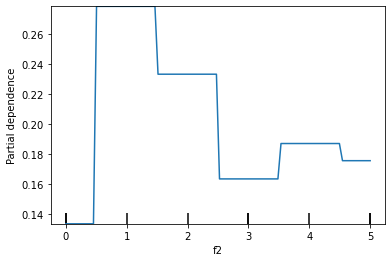

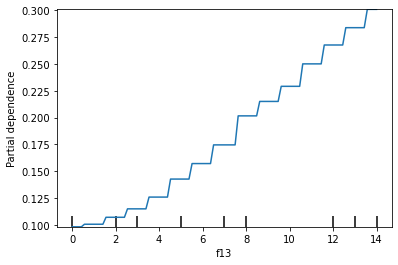

In [58]:
top_2_features = ['f2', 'f13']
for feat in top_2_features:
    PartialDependenceDisplay.from_estimator(clf, X_tr, [feat])

We see that instances, on average, are more likely to be predicted as '1' when f2 has a value of 1. As the value of f2 increases, this chance lowers. Meanwhile, f13 linearly contributes more and more to the prediction of class '1' as the value increases. Thus, we can say that an instance with f2=1 and a high value of f13=13 has a lot higher likelihood of being predicted as class '1', than an instance where f2=0 value and f13=0.